In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from itertools import chain
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
import joblib

# Mis utilitarios
# from utils import *


In [ ]:

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Concatenate, ConvLSTM2D, Reshape, Conv2D, Lambda
from tensorflow.keras.initializers import Constant
from tensorflow.keras.utils import plot_model

# Set Path

In [ ]:
el_path_main = Path(os.getcwd()).parent
el_path_main

PosixPath('/')

In [ ]:
# En caso sea en google Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Tensors

In [ ]:
# X_gts_train, Y_train, X_gts_miss_train, X_ctry_lvl_train = joblib.load(el_path_main / '2. Datos/Processed data/TRAIN_data.pkl')
# X_gts_oot, Y_oot, X_gts_miss_oot, X_ctry_lvl_oot = joblib.load(el_path_main / '2. Datos/Processed data/OOT_data.pkl')

In [ ]:
# Para el caso de google cloud
X_gts_train, Y_train, X_gts_miss_train, X_ctry_lvl_train = joblib.load('/content/drive/MyDrive/Bourbaki/DLA2501 - Deep Learning Avanzado/Flood forecasting/TRAIN_data.pkl')
# X_gts_oot, Y_oot, X_gts_miss_oot, X_ctry_lvl_oot = joblib.load('/content/drive/MyDrive/Bourbaki/DLA2501 - Deep Learning Avanzado/Flood forecasting/OOT_data.pkl')


In [ ]:
# Reducimos el tamaño del dataset para que pueda ser ejecutado en local
desde_index = 600
X_gts_train = X_gts_train[desde_index:,:]
Y_train = Y_train[desde_index:,:]
X_gts_miss_train = X_gts_miss_train[desde_index:,:]
X_ctry_lvl_train = X_ctry_lvl_train[desde_index:,:]

In [ ]:
# X_gts_train.shape, Y_train.shape, X_gts_miss_oot.shape, X_ctry_lvl_oot.shape
X_gts_train.shape, Y_train.shape, X_gts_miss_train.shape, X_ctry_lvl_train.shape

((577, 10, 96, 36, 28), (577, 12, 36, 28), (577, 10, 96, 36, 28), (577, 180))

In [ ]:
def format_Y(Y):
    """
    Formatea Y para que sea un array de numpy con la forma (n_samples, n_classes)
    """
    Y = np.array(Y)
    Y = to_categorical(Y, num_classes=2)
    return Y

In [ ]:
Y_train_f = format_Y(Y_train)
# Y_oot_f = format_Y(Y_oot)

In [ ]:
X_gts_train.shape, Y_train.shape, X_gts_miss_train.shape, X_ctry_lvl_train.shape

((577, 10, 96, 36, 28), (577, 12, 36, 28), (577, 10, 96, 36, 28), (577, 180))

In [ ]:
def gen_X_gts_for_model(X_gts, X_gts_miss):
    n_vars = X_gts.shape[1]
    lista_array = []
    for var in range(n_vars):
        X_tmp      = np.expand_dims(X_gts[:, var, :], -1)
        X_tmp_miss = np.expand_dims(X_gts_miss[:, var, :], -1)
        X = np.concat((X_tmp, X_tmp_miss), axis=-1)
        lista_array.append(X)
    return lista_array

In [ ]:
# la_lista_de_arrays_oot = gen_X_gts_for_model(X_gts_oot, X_gts_miss_oot)
la_lista_de_arrays_train = gen_X_gts_for_model(X_gts_train, X_gts_miss_train)

In [ ]:
la_lista_de_arrays_train[0].shape

(577, 96, 36, 28, 2)

# Version Simple

In [ ]:
n_vars_from_gts = X_gts_train.shape[1] # N of variables from GTS
n_times_for_lstm = X_gts_train.shape[2] # N of time steps usted for LSTM
n_lats = X_gts_train.shape[3] # N of latitudes
n_lons = X_gts_train.shape[4] # N of longitudes
vars_ctry_lvl = X_ctry_lvl_train.shape[1] # N of variables from country level data
n_codmes_fcast = Y_train.shape[1] # N of codmes for forecast

# Set of parameters that will be tunned
recurrent_dropout = 0.2
dropout = 0.2
n_filters = 2
kernel_size = 3
include_miss_layer = True
dims_nn_ctry_lvl_tmp = [16] # La longitud de esta lista indica la cantidad de capas -1 (colcoar lista vacía para que sea de tamaño 1), los valores dentro indican el tamaño de la capa

# Set of parameters that are based on the previous ones
n_channels_conv_lstm = 2 if include_miss_layer else 1
dims_nn_ctry_lvl = dims_nn_ctry_lvl_tmp+[n_lats*n_lons*n_channels_conv_lstm] # La longitud de esta lista indica la cantidad de capas, los valores dentro indican el tamaño de la capa

In [ ]:
def repeat_latent(x):
    return tf.repeat(x, repeats=n_codmes_fcast, axis=1)  # Repeat along time axis

In [ ]:
mi_inp_gts = Input(shape=(n_times_for_lstm, n_lats, n_lons, n_channels_conv_lstm, ), name=f'input_gts')
mi_inp_ctry = Input(shape=(vars_ctry_lvl, ), name=f'input_ctry')

mi_lstm = ConvLSTM2D(filters=n_filters,
                     kernel_size=(kernel_size, kernel_size),
                     padding='same',
                     data_format = 'channels_last',
                     return_sequences=False,
                     recurrent_dropout=recurrent_dropout,
                     dropout=dropout,
                     name='conv_lstm_1')(mi_inp_gts)

mi_dense_ctry = Dense(36*28, activation='relu')(mi_inp_ctry)
mi_dense_ctry = Reshape((36, 28, 1))(mi_dense_ctry)

mi_encoded = Concatenate(axis=-1)([mi_lstm, mi_dense_ctry])
mi_encoded = Reshape((1, n_lats, n_lons, 3))(mi_encoded)
mi_encoded = Lambda(repeat_latent)(mi_encoded)

mi_decoder = ConvLSTM2D(filters=n_filters,
                        kernel_size=(kernel_size, kernel_size),
                        padding='same',
                        data_format = 'channels_last',
                        return_sequences=True,
                        recurrent_dropout=recurrent_dropout,
                        dropout=dropout,
                        name='conv_lstm_2')(mi_encoded)
output = TimeDistributed(Conv2D(2, (1, 1), activation='softmax'))(mi_decoder)
# Model
mi_simple_model = Model(inputs=[mi_inp_gts, mi_inp_ctry], outputs=output)
mi_simple_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
mi_simple_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ctry          │ (None, 180)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_gts           │ (None, 96, 36,    │          0 │ -                 │
│ (InputLayer)        │ 28, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1008)      │    182,448 │ input_ctry[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm_1         │ (None, 36, 28, 2) │        296 │ input_gts[0][0]   │
│ (ConvLSTM2D)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 36, 28, 1) │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 36, 28, 3) │          0 │ conv_lstm_1[0][0… │
│ (Concatenate)       │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1, 36, 28, │          0 │ concatenate[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 12, 36,    │          0 │ reshape_1[0][0]   │
│                     │ 28, 3)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm_2         │ (None, 12, 36,    │        368 │ lambda[0][0]      │
│ (ConvLSTM2D)        │ 28, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 12, 36,    │          6 │ conv_lstm_2[0][0] │
│ (TimeDistributed)   │ 28, 2)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 183,118 (715.30 KB)

 Trainable params: 183,118 (715.30 KB)

 Non-trainable params: 0 (0.00 B)

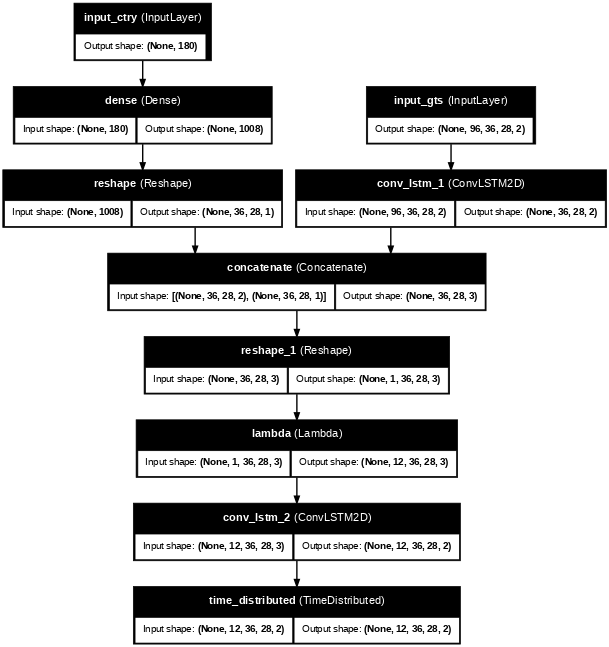

In [ ]:
plot_model(
    mi_simple_model,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TD",
    dpi=50,
)

In [ ]:
mi_simple_model.compile(optimizer='adam',         # el optimizador sirve para encontrar los pesos que minimizan la función de pérdida
                                            # adam: stochastic gradient descent adaptativo
                                            # https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
                  loss="categorical_crossentropy", # función que evalua que tan bien el algoritmo modela el conjunto de datos
                                                   # https://www.tensorflow.org/api_docs/python/tf/keras/losses
                  metrics=['accuracy'])

# mi_simple_model_history = mi_simple_model.fit(x = [la_lista_de_arrays_train[9], X_ctry_lvl_train],
#                          y = Y_train_f,
#                         validation_split=0.2,
#                         batch_size=128,
#                         epochs=20,   # número de iteraciones sobre los datos
#                         verbose=1)

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.8296 - loss: 0.6443 - val_accuracy: 0.8570 - val_loss: 0.6095
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 264ms/step - accuracy: 0.8339 - loss: 0.6299 - val_accuracy: 0.8739 - val_loss: 0.5936
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 264ms/step - accuracy: 0.8415 - loss: 0.6176 - val_accuracy: 0.8804 - val_loss: 0.5840
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 265ms/step - accuracy: 0.8463 - loss: 0.6065 - val_accuracy: 0.8759 - val_loss: 0.5748
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 266ms/step - accuracy: 0.8492 - loss: 0.5951 - val_accuracy: 0.8808 - val_loss: 0.5637
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 266ms/step - accuracy: 0.8561 - loss: 0.5818 - val_accuracy: 0.8832 - val_loss: 0.5508
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 265ms/step - accuracy: 0.8597 - loss: 0.5709 - val_accuracy: 0.8861 - val_loss: 0.5394
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 266ms/step - accuracy: 0.8621 - loss: 0.5601 - val_accuracy: 0.8978 - val_loss: 0

In [ ]:
# mi_simple_model.save_weights(el_path_main/'4. Analisis/mi_simple_model.weights.h5')


In [ ]:
# En cloud
# mi_simple_model.save_weights('/content/drive/MyDrive/Bourbaki/DLA2501 - Deep Learning Avanzado/Flood forecasting/mi_simple_model.weights.h5')

# Conv-LSTM

In [ ]:
n_vars_from_gts = X_gts_train.shape[1] # N of variables from GTS
n_times_for_lstm = X_gts_train.shape[2] # N of time steps usted for LSTM
n_lats = X_gts_train.shape[3] # N of latitudes
n_lons = X_gts_train.shape[4] # N of longitudes
vars_ctry_lvl = X_ctry_lvl_train.shape[1] # N of variables from country level data
n_codmes_fcast = Y_train.shape[1] # N of codmes for forecast

# Set of parameters that will be tunned
recurrent_dropout = 0.2
dropout = 0.2
n_filters = 2
kernel_size = 3
include_miss_layer = True
dims_nn_ctry_lvl_tmp = [3] # La longitud de esta lista indica la cantidad de capas -1 (colcoar lista vacía para que sea de tamaño 1), los valores dentro indican el tamaño de la capa

# Set of parameters that are based on the previous ones
n_channels_conv_lstm = 2 if include_miss_layer else 1
dims_nn_ctry_lvl = dims_nn_ctry_lvl_tmp+[n_lats*n_lons*n_channels_conv_lstm] # La longitud de esta lista indica la cantidad de capas, los valores dentro indican el tamaño de la capa

In [ ]:
def repeat_latent(x):
    return tf.repeat(x, repeats=n_codmes_fcast, axis=1)  # Repeat along time axis

In [ ]:
# Inputs for each variable from GTS
map_inputs = [Input(shape=(n_times_for_lstm, n_lats, n_lons, n_channels_conv_lstm, ), name=f'input_gts_{i}') for i in range(n_vars_from_gts)]

# ConvLSTM encoding for maps
conv_outputs = [
    ConvLSTM2D(
            filters = n_filters,
            kernel_size = (kernel_size, kernel_size), # Tamaño del kernel
            padding = 'same', # Para que la salida tenga el mismo tamaño que la entrada
            data_format = 'channels_last', # Forma en que recibe los datos:Docu -> 5D tensor with shape: (samples, time, rows, cols, channels)
            return_sequences = False, # No retorna cada secuencia de salida
            # return_state=True, # Retorna los estados ocultos de la capa LSTM
            recurrent_dropout = recurrent_dropout, dropout = dropout  # Para evitar sobreajuste
            )(inp)
    for inp in map_inputs
]

# Input country level data
input_ctry_lvl = Input(shape=(vars_ctry_lvl,), name='input_ctry_lvl')
mi_dense_ctry_lvl = input_ctry_lvl

# Dense layers for country level data
for i in dims_nn_ctry_lvl:
    mi_dense_ctry_lvl = Dense(i, activation='relu')(mi_dense_ctry_lvl)

# Reshape so that it is compatible with the outputs of the LSTM.
mi_dense_ctry_lvl = Reshape((n_lats, n_lons, n_channels_conv_lstm))(mi_dense_ctry_lvl)

# Concatenate all the outputs of the LSTM layers and the dense layer for country level data
mi_concat = Concatenate()(conv_outputs+[mi_dense_ctry_lvl])
latent = Conv2D(n_filters, kernel_size=(kernel_size, kernel_size), padding='same', activation='relu')(mi_concat)
latent = Reshape((1, n_lats, n_lons, n_filters))(latent)


# Decoder
decoder_input = Lambda(repeat_latent)(latent)
decoder = ConvLSTM2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), padding='same', return_sequences=True)(decoder_input)

# Multi-class output
output = TimeDistributed(Conv2D(2, (1, 1), activation='softmax'))(decoder)

# Model
model = Model(inputs = map_inputs + [input_ctry_lvl], outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ctry_lvl      │ (None, 180)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 3)         │        543 │ input_ctry_lvl[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_gts_0         │ (None, 96, 36,    │          0 │ -                 │
│ (InputLayer)        │ 28, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_gts_1         │ (None, 96, 36,    │          0 │ -                 │
│ (InputLayer)        │ 28, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_gts_2         │ (None, 96, 36,    │          0 │ -                 │
│ (InputLayer)        │ 28, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_gts_3         │ (None, 96, 36,    │          0 │ -                 │
│ (InputLayer)        │ 28, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_gts_4         │ (None, 96, 36,    │          0 │ -                 │
│ (InputLayer)        │ 28, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_gts_5         │ (None, 96, 36,    │          0 │ -                 │
│ (InputLayer)        │ 28, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_gts_6         │ (None, 96, 36,    │          0 │ -                 │
│ (InputLayer)        │ 28, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_gts_7         │ (None, 96, 36,    │          0 │ -                 │
│ (InputLayer)        │ 28, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_gts_8         │ (None, 96, 36,    │          0 │ -                 │
│ (InputLayer)        │ 28, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_gts_9         │ (None, 96, 36,    │          0 │ -                 │
│ (InputLayer)        │ 28, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 2016)      │      8,064 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d         │ (None, 36, 28, 2) │        296 │ input_gts_0[0][0] │
│ (ConvLSTM2D)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_1       │ (None, 36, 28, 2) │        296 │ input_gts_1[0][0] │
│ (ConvLSTM2D)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_2       │ (None, 36, 28, 2) │        296 │ input_gts_2[0][0] │
│ (ConvLSTM2D)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_3       │ (None, 36, 28, 2) │        296 │ input_gts_3[0][0] │
│ (ConvLSTM2D)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 12,267 (47.92 KB)

 Trainable params: 12,267 (47.92 KB)

 Non-trainable params: 0 (0.00 B)

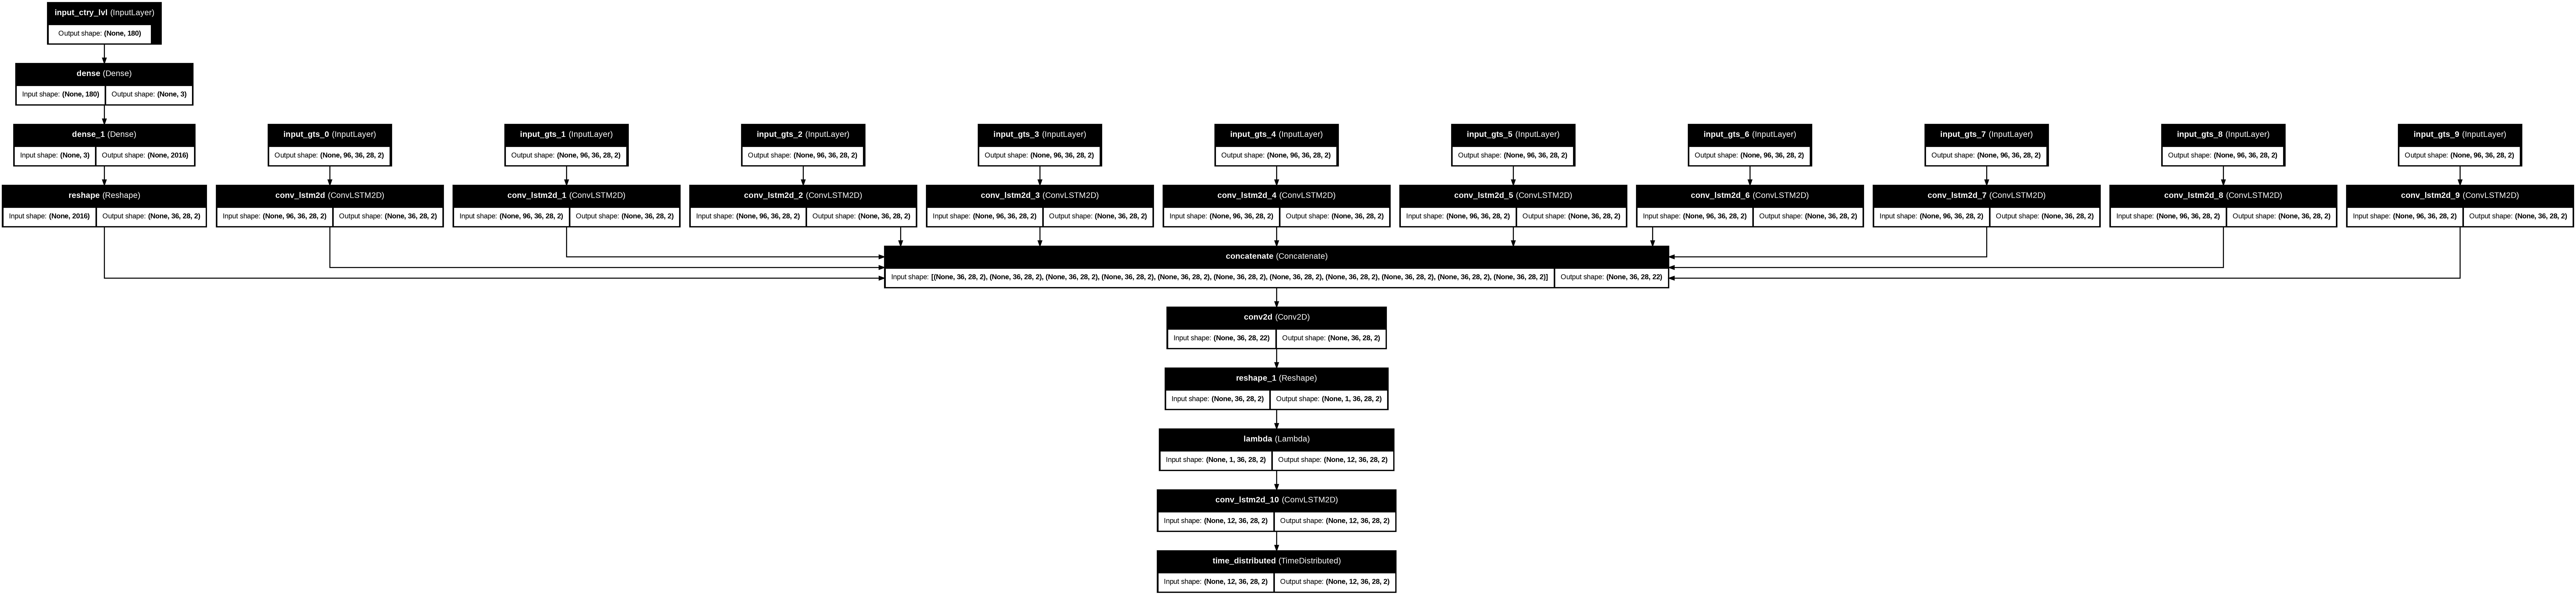

In [ ]:
plot_model(
    model,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TD",
    dpi=200,
)

In [ ]:
model.compile(optimizer='adam',         # el optimizador sirve para encontrar los pesos que minimizan la función de pérdida
                                            # adam: stochastic gradient descent adaptativo
                                            # https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
                  loss="categorical_crossentropy", # función que evalua que tan bien el algoritmo modela el conjunto de datos
                                                   # https://www.tensorflow.org/api_docs/python/tf/keras/losses
                  metrics=['accuracy'])

In [ ]:
history = model.fit(x = la_lista_de_arrays_train + [X_ctry_lvl_train],
                         y = Y_train_f,
                        validation_split=0.2,
                        batch_size=60,
                        epochs=20,   # número de iteraciones sobre los datos
                        verbose=1)

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 159s 11s/step - accuracy: 0.7147 - loss: 0.9289 - val_accuracy: 0.7583 - val_loss: 0.8670
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.7649 - loss: 0.8585 - val_accuracy: 0.7863 - val_loss: 0.8274
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.7930 - loss: 0.8178 - val_accuracy: 0.8130 - val_loss: 0.7867
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.8153 - loss: 0.7841 - val_accuracy: 0.8213 - val_loss: 0.7675
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.8252 - loss: 0.7630 - val_accuracy: 0.8328 - val_loss: 0.7471
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.8373 - loss: 0.7425 - val_accuracy: 0.8413 - val_loss: 0.7316
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.8423 - loss: 0.7299 - val_accuracy: 0.8433 - val_loss: 0.7222
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.8453 - loss: 0.7198 - val_accuracy: 0.8486 - val_loss: 0.7089
Epoch 

In [ ]:
# model.save_weights(el_path_main/'4. Analisis/model.weights.h5')

In [ ]:
# Si es en google Colab (modelo con)
model.save_weights('/content/drive/MyDrive/Bourbaki/DLA2501 - Deep Learning Avanzado/Flood forecasting/ModeloGrande_v1.weights.h5')

# Benchmark (Logit)